In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd

In [2]:
increase_amt = 15 #per grid box #kg/m2/s

In [3]:
#ECA, TIB, EAS

In [4]:
path = '../GCrundirs/IRF_runs/mod_inputs/BC-em-total-anthro_CEDS_2016'

In [5]:
ds = xr.open_dataset(path + '.nc', engine = "netcdf4")

# CEDS Uniform Pulse

In [14]:
### create a pulsed dataset
pulse_ds =  ds['BC_ene'].copy()
pulse_ds *= increase_amt

In [15]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

In [18]:
ar6_coal_location

{8: 'CAR',
 4: 'CNA',
 35: 'EAS',
 41: 'EAU',
 33: 'ECA',
 18: 'EEU',
 5: 'ENA',
 26: 'ESAF',
 30: 'ESB',
 27: 'MDG',
 19: 'MED',
 6: 'NCA',
 11: 'NES',
 16: 'NEU',
 1: 'NWN',
 9: 'NWS',
 43: 'NZ',
 28: 'RAR',
 31: 'RFE',
 20: 'SAH',
 37: 'SAS',
 42: 'SAU',
 7: 'SCA',
 38: 'SEA',
 14: 'SES',
 13: 'SWS',
 34: 'TIB',
 32: 'WCA',
 17: 'WCE',
 3: 'WNA',
 25: 'WSAF',
 29: 'WSB'}

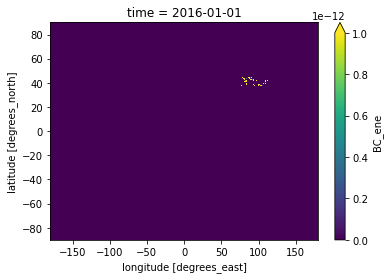

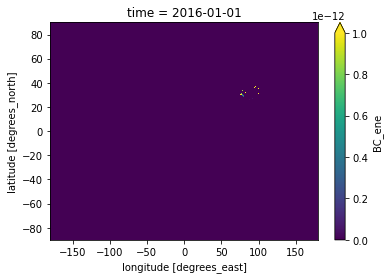

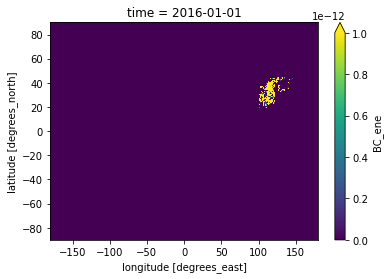

In [20]:
### Global: Modify CEDs files
regions = regionmask.defined_regions.ar6.land
for r in [33, 34, 35]:#ar6_coal_location: 
    ds_new = ds.copy()
    mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == r)
    ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
    ds_new['BC_ene'] = ds_pulse_reg.fillna(0) + ds_new['BC_ene'] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
    ds_new['BC_ene'].attrs = ds['BC_ene'].attrs
    fig, ax = plt.subplots()
    ((ds_new['BC_ene']).isel(time = 0)-(ds['BC_ene']).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
    ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + '.nc')

# CEDS Weighted by existing patterns

# CEDS Cosine Weighted

In [5]:
#estimated center of the US at 47 N 101 W

In [6]:
center = ds.sel(lon = -98, lat = 39, method = 'nearest')

In [7]:
lat_w = 20 #degrees (doing 2x our grid size, can change)
lon_w = 25 #degrees (doing 2x our grid size, can change)

In [8]:
A = increase_amt

In [9]:
pulse_ds = A*np.cos(np.pi/2 * (ds['lat'] - center['lat'])/lat_w)**2 * np.cos(np.pi/2 * (ds['lon'] - center['lon'])/lon_w)**2

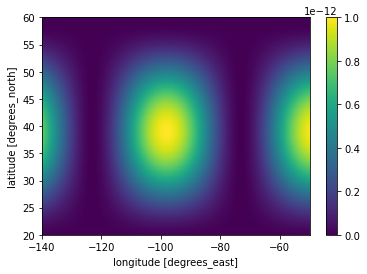

In [29]:
pulse_ds.plot()

In [10]:
us_pulse = pulse_ds.loc[dict(lat = slice(center['lat']-lat_w, center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w, center['lon']+lon_w))].rename('pulse')

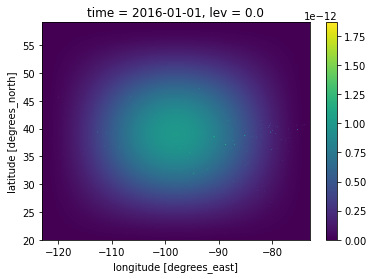

In [11]:
(ds['PEC']+pulse_ds.loc[dict(lat = slice(center['lat']-lat_w,center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w,center['lon']+lon_w))]).isel(time = 0, lev = 0).plot()

In [12]:
ds_out = xr.merge([ds['PEC'], us_pulse])

In [13]:
ds_out['pulse'] = ds_out['pulse'].fillna(0)

In [14]:
ds_out['pulse_added'] = (ds_out['PEC'] + ds_out['pulse'])

In [15]:
ds_out['pulse_added'].attrs = ds['PEC'].attrs

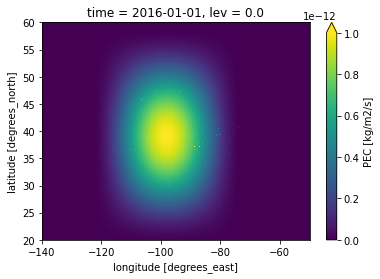

In [16]:
(ds_out['pulse_added']).isel(lev = 0).plot(vmax = 1e-12)

In [25]:
ds['PEC'] = ds_out['pulse_added'].astype('float32')

In [27]:
ds['PEC'].dtype

dtype('float32')

In [28]:
ds.to_netcdf(path + '_us_cos_pulse.nc')

# US Only, NEI Modification

01 done


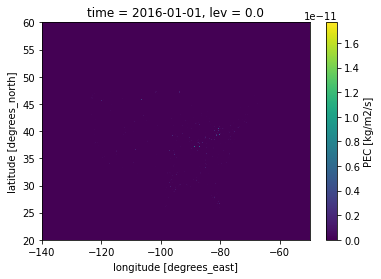

In [30]:
### US Only (modify NEI Files)
# POC for OC (in NEI)
# PEC for BC (in NEI)
poll = 'PEC'
increase_amt = 15
for m in ['01']:#,'04','07','10']:

    ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")
    ds[poll] *= increase_amt
    ds[poll].isel(time = 0, lev = 0).plot()
    #ds.to_netcdf(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}_mod_{poll}_varied.ncf')
    print(m, 'done')

In [35]:
ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")